# Reproducing Figure 5

In [1]:
###################
# Import packages #
###################

import arviz as az
import matplotlib.pylab as plt
import sys
sys.path.append('../code/')
from makeCorner import *

In [2]:
##############################
# Things related to plotting #
##############################

import matplotlib.pylab as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"]="Times New Roman"
rc_fonts = {
"text.usetex": True,
}
plt.rcParams.update(rc_fonts)
plt.rcParams["figure.figsize"] = (8,6) 

import seaborn as sns
my_palette = sns.color_palette("colorblind")

## Load in O3 results for comparison

In [3]:
data_CBC_GWB_O3 = az.from_netcdf("../data/O3_CBC_GWB_MD.nc")
# az.summary(data_CBC_GWB_O3) # Uncomment to see statistics of the parameters inferred during the parameter estimation run

In [4]:
stacked_samples_O3 = data_CBC_GWB_O3.posterior.stack(draws=("chain", "draw"))

toPlot_O3 = {
    "lambda_td":{"data":stacked_samples_O3.lambda_td,"plot_bounds":(-7,1),"label":r"$\kappa$"},
    "logmetMin_td":{"data":stacked_samples_O3.logmetMin_td,"plot_bounds":(-4,0.1),"label":r"$\log Z^{\rm max}/Z_\odot$"},
    "log_td_min":{"data":stacked_samples_O3.log_td_min,"plot_bounds":(-3,0),"label":r"$\log t_d^{\rm min}$/Gyrs"}
}

## Load in O5 results and plotting

In [5]:
data_CBC_GWB_undetectable_O5 = az.from_netcdf("../data/O5_CBC_GWB_undetectable_MD.nc")
# az.summary(data_CBC_GWB_undetectable_O5) # Uncomment to see statistics of the parameters inferred during the parameter estimation run

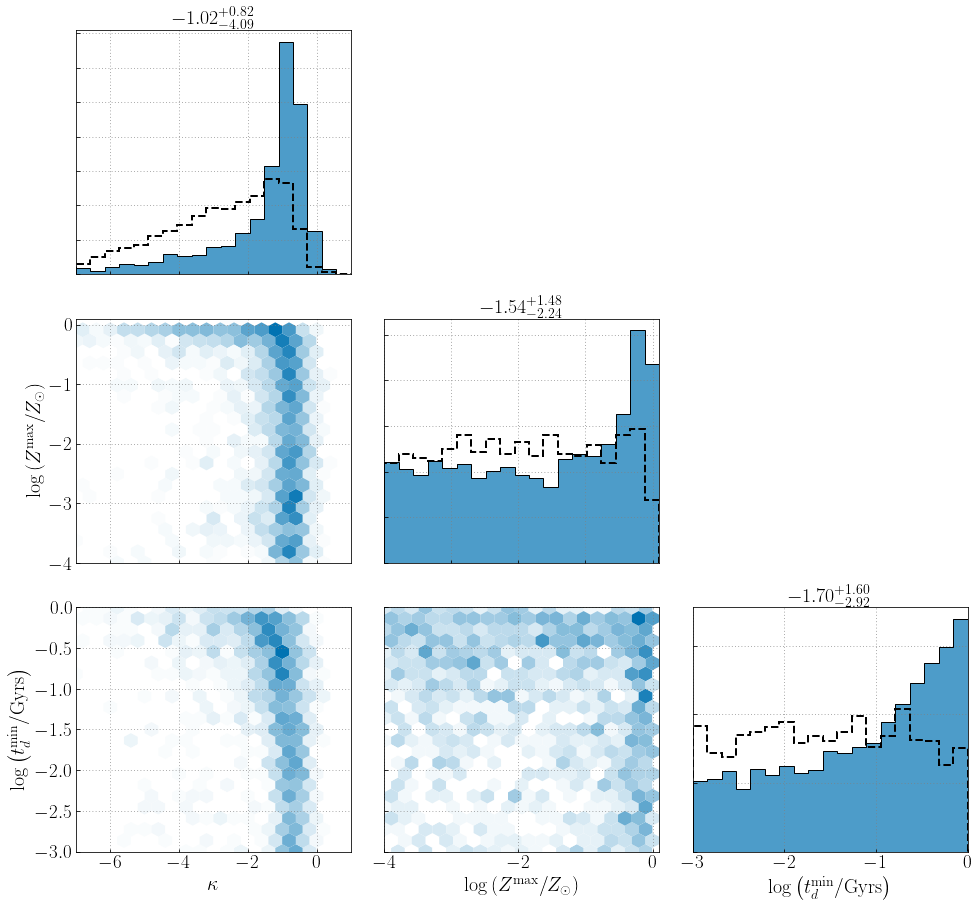

In [6]:
fig = plt.figure(figsize=(14,13))

stacked_samples_undetectable_O5 = data_CBC_GWB_undetectable_O5.posterior.stack(draws=("chain", "draw"))

toPlot_undetectable_O5 = {
    "lambda_td":{"data":stacked_samples_undetectable_O5.lambda_td,"plot_bounds":(-7,1),"label":r"$\kappa$"},
    "logmetMin_td":{"data":stacked_samples_undetectable_O5.logmetMin_td,"plot_bounds":(-4,0.1),"label":r"$\log \left(Z^{\rm max}/Z_\odot\right)$"},
    "log_td_min":{"data":stacked_samples_undetectable_O5.log_td_min,"plot_bounds":(-3,0),"label":r"$\log \left(t_d^{\rm min}/{\rm Gyrs}\right)$"}
}

plot_corner_plus_hist_contour(fig,toPlot_undetectable_O5,toPlot_O3,color=my_palette[0],labelsize=22)
plt.tight_layout()
plt.savefig("PosteriorO5undetectable.pdf",dpi=500,bbox_inches='tight')
plt.show()